<h1>Assignment 4: Implementing linear classifiers</h1>
<p>Andreas Koj</p>

In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

X1 = [{'city':'Gothenburg', 'month':'July'},
      {'city':'Gothenburg', 'month':'December'},
      {'city':'Paris', 'month':'July'},
      {'city':'Paris', 'month':'December'}]
Y1 = ['rain', 'rain', 'sun', 'rain']

X2 = [{'city':'Sydney', 'month':'July'},
      {'city':'Sydney', 'month':'December'},
      {'city':'Paris', 'month':'July'},
      {'city':'Paris', 'month':'December'}]
Y2 = ['rain', 'sun', 'sun', 'rain']

classifier1 = make_pipeline(DictVectorizer(), Perceptron(max_iter=10))
classifier1.fit(X1, Y1)
guesses1 = classifier1.predict(X1)
print(accuracy_score(Y1, guesses1))

classifier2 = make_pipeline(DictVectorizer(), Perceptron(max_iter=10))
classifier2 = make_pipeline(DictVectorizer(), SVC())

classifier2.fit(X2, Y2)
guesses2 = classifier2.predict(X2)
print(accuracy_score(Y2, guesses2))

1.0
1.0


Exercise question answer:

Perceptron and LinearSVC are linear classifiers, the output of this functions is a strait line which tries to seperate two classes (rain,sun)in this case. The output 50% means that the sperator (function) has problem to devide these classes (The problem is not linear seperable). To solve this problem we can use non linear classifier like for example SVC with default radial basis function kernel.



![title](data/p1.jpg)

<h1>LinearSVC implementation</h1>

In [2]:
import numpy as np
from sklearn.base import BaseEstimator

class LinearClassifier(BaseEstimator):
    """
    General class for binary linear classifiers. Implements the predict
    function, which is the same for all binary linear classifiers. There are
    also two utility functions.
    """

    def decision_function(self, X):
        """
        Computes the decision function for the inputs X. The inputs are assumed to be
        stored in a matrix, where each row contains the features for one
        instance.
        """
        return X.dot(self.w)

    def predict(self, X):
        """
        Predicts the outputs for the inputs X. The inputs are assumed to be
        stored in a matrix, where each row contains the features for one
        instance.
        """

        # First compute the output scores
        scores = self.decision_function(X)

        # Select the positive or negative class label, depending on whether
        # the score was positive or negative.
        out = np.select([scores >= 0.0, scores < 0.0],
                        [self.positive_class,
                         self.negative_class])
        return out

    def find_classes(self, Y):
        """
        Finds the set of output classes in the output part Y of the training set.
        If there are exactly two classes, one of them is associated to positive
        classifier scores, the other one to negative scores. If the number of
        classes is not 2, an error is raised.
        """
        classes = sorted(set(Y))
        if len(classes) != 2:
            raise Exception("this does not seem to be a 2-class problem")
        self.positive_class = classes[1]
        self.negative_class = classes[0]

    def encode_outputs(self, Y):
        """
        A helper function that converts all outputs to +1 or -1.
        """
        return np.array([1 if y == self.positive_class else -1 for y in Y])


class linearSVC(LinearClassifier):

    def __init__(self, n_iter=20, lam=1):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.lam = lam

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        
        self.w = np.zeros(n_features)
    
        # The Pegasos algorithm 
        t = 0
        for i in range(self.n_iter):
            for x, y in zip(X, Ye):
                t = t+1
                n = 1/(self.lam*t)
                
                score = x.dot(self.w)
                
                if y*score < 1:
                    self.w = (1-n*self.lam)*self.w + (n*y)*x
                else:
                    self.w = (1-n*self.lam) * self.w


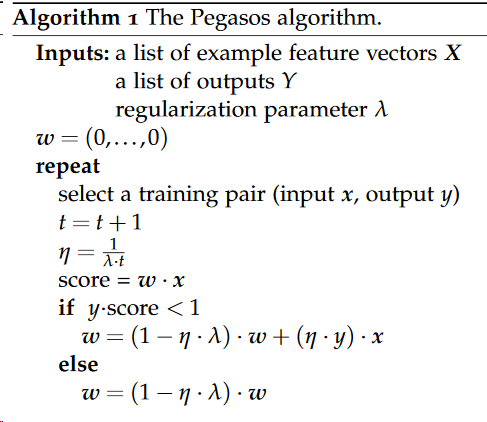

<h1>Training custom Linear SVC</h1>
<p>I choose lamba= 0.0001 experimentally which gave me the best accuracy, almost 84%</p>

In [3]:
import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#from aml_perceptron import Perceptron, SparsePerceptron

# This function reads the corpus, returns a list of documents, and a list
# of their corresponding polarity labels. 
def read_data(corpus_file):
    X = []
    Y = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            _, y, _, x = line.split(maxsplit=3)
            X.append(x.strip())
            Y.append(y)
    return X, Y

 
# Read all the documents.
X, Y = read_data('data/all_sentiment_shuffled.txt')

# Split into training and test parts.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2,
                                                random_state=0)

# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=2000),
    Normalizer(),

    linearSVC(lam=0.0001, n_iter=30)  
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))


Training time: 4.80 sec.
Accuracy: 0.8393.


<h1>Training custom Logistic Regression</h1>

In [5]:
import numpy as np
from sklearn.base import BaseEstimator

class LinearClassifier(BaseEstimator):
    """
    General class for binary linear classifiers. Implements the predict
    function, which is the same for all binary linear classifiers. There are
    also two utility functions.
    """

    def decision_function(self, X):
        """
        Computes the decision function for the inputs X. The inputs are assumed to be
        stored in a matrix, where each row contains the features for one
        instance.
        """
        return X.dot(self.w)

    def predict(self, X):
        """
        Predicts the outputs for the inputs X. The inputs are assumed to be
        stored in a matrix, where each row contains the features for one
        instance.
        """

        # First compute the output scores
        scores = self.decision_function(X)

        # Select the positive or negative class label, depending on whether
        # the score was positive or negative.
        out = np.select([scores >= 0.0, scores < 0.0],
                        [self.positive_class,
                         self.negative_class])
        return out

    def find_classes(self, Y):
        """
        Finds the set of output classes in the output part Y of the training set.
        If there are exactly two classes, one of them is associated to positive
        classifier scores, the other one to negative scores. If the number of
        classes is not 2, an error is raised.
        """
        classes = sorted(set(Y))
        if len(classes) != 2:
            raise Exception("this does not seem to be a 2-class problem")
        self.positive_class = classes[1]
        self.negative_class = classes[0]

    def encode_outputs(self, Y):
        """
        A helper function that converts all outputs to +1 or -1.
        """
        return np.array([1 if y == self.positive_class else -1 for y in Y])


class linearRegression(LinearClassifier):

    def __init__(self, n_iter=20, lam=1):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.lam = lam

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        
        self.w = np.zeros(n_features)
    
        # The Pegasos algorithm 
        t = 0
#         for i in range(self.n_iter):
#             for x, y in zip(X, Ye):
#                 t = t+1
#                 n = 1/(self.lam*t)
                
#                 score = x.dot(self.w)
                
#                 if y*score < 1:
#                     self.w = (1-n*self.lam)*self.w + (n*y)*x
#                 else:
#                     self.w = (1-n*self.lam) * self.w

                    
#Loss(w, xi,yi) = log(1 + exp(−yi · (w · xi)))